In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
from climatico.util import weighted_mean, pacific_lon
import subprocess
import copy
#import os

In [2]:
from config import directory_figs, directory_data

In [3]:
# list of filenames to do this for
file_g02sv = 'b1d.e11.B1850LENS.f09_g16.FWAtSalG02Sv.pop.h.SST.*.nc'
file_g04sv = 'b1d.e11.B1850LENS.f09_g16.FWAtSalG04Sv.pop.h.SST.*.nc'
file_p02sv = 'b1d.e11.B1850LENS.f09_g16.FWAtSalP02Sv.pop.h.SST.*.nc'
file_p04sv = 'b1d.e11.B1850LENS.f09_g16.FWAtSalP04Sv.pop.h.SST.*.nc'
file_psalt = 'b1d.e11.B1850LENS.f09_g16.FWPaSalP04Sv.pop.h.SST.*.nc'
file_cntrl = 'b1d.e11.B1850C5CN.f09_g16.005.pop.h.SST.*.nc'

In [4]:
ds_cntrl = xr.open_mfdataset(f'{directory_data}{file_cntrl}', combine='by_coords')
ds_cntrl = ds_cntrl.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(1001, 1, 1, 0, 0),cftime.DatetimeNoLeap(1300, 12, 1, 0, 0)))

ds_g02sv = xr.open_mfdataset(f'{directory_data}{file_g02sv}', combine='by_coords')
ds_g02sv = ds_g02sv.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(201, 1, 1, 0, 0),cftime.DatetimeNoLeap(500, 12, 1, 0, 0)))

ds_g04sv = xr.open_mfdataset(f'{directory_data}{file_g04sv}', combine='by_coords')
ds_g04sv = ds_g04sv.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(201, 1, 1, 0, 0),cftime.DatetimeNoLeap(500, 12, 1, 0, 0)))

ds_p02sv = xr.open_mfdataset(f'{directory_data}{file_p02sv}', combine='by_coords')
ds_p02sv = ds_p02sv.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(201, 1, 1, 0, 0),cftime.DatetimeNoLeap(500, 12, 1, 0, 0)))

ds_p04sv = xr.open_mfdataset(f'{directory_data}{file_p04sv}', combine='by_coords')
ds_p04sv = ds_p04sv.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(201, 1, 1, 0, 0),cftime.DatetimeNoLeap(500, 12, 1, 0, 0)))

ds_psalt = xr.open_mfdataset(f'{directory_data}{file_psalt}', combine='by_coords')
ds_psalt = ds_psalt.isel(z_t=0)['SST'].sel(time=slice(cftime.DatetimeNoLeap(101, 1, 1, 0, 0),cftime.DatetimeNoLeap(250, 12, 1, 0, 0)))

In [5]:
def grab_wghtmean(ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt,
                  lon1 = 170.5, lon2 = -150.5, lat1 = 30.5, lat2 = 40.5):
    """
    Compute weighted mean for the select region.
    
    Args:
        ds_cntrl: Xarray data array for control. 
        ds_g02sv: Xarray data array for 0.2 Sv global experiment.
        ds_g04sv: Xarray data array for 0.4 Sv global experiment.
        ds_p02sv: Xarray data array for 0.2 Sv pacific experiment.
        ds_p04sv: Xarray data array for 0.4 Sv pacific experiment.
        ds_psalt: Xarray data array for pacific salt experiment. 
        lon1 (float): Lower left corner longitude. Defaults to ``170.5``.
        lon2 (float): Upper right corner longitude. Defaults to ``-150.5``.
        lat1 (float): Lower left corner latitude. Defaults to ``30.5``.
        lat2 (float): Upper right corner latitude. Defaults to ``40.5``.
    """
    ds_cntrl_box = weighted_mean(ds_cntrl.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')

    ds_g02sv_box = weighted_mean(ds_g02sv.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')

    ds_g04sv_box = weighted_mean(ds_g04sv.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')

    ds_p02sv_box = weighted_mean(ds_p02sv.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')

    ds_p04sv_box = weighted_mean(ds_p04sv.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')

    ds_psalt_box = weighted_mean(ds_psalt.sel(
        lon=slice(pacific_lon(lon1, to180=False), pacific_lon(lon2, to180=False)), 
        lat=slice(lat1, lat2)), lat_name='lat')
    
    return ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box

In [6]:
def grab_specx(da, variable='SST'):
    """
    Calling to ncl directory to use spectral analysis ncl scripts.
    Input your directory into the function.
    Use ``os.path.dirname(os.getcwd())+'/ncl/'`` to find your respective path.

    Args:
        da: Xarray data array .
        variables (str): Variable name. Defaults to ``SST``.
    """
    da.to_dataset(name=variable).to_netcdf('/glade/u/home/molina/python_scripts/climatico/ncl/box_sst.nc')
    subprocess.call([f'ml intel/18.0.5; ml ncl; ncl /glade/u/home/molina/python_scripts/climatico/ncl/specx_anal.ncl'], shell=True)
    spcx = xr.open_dataset("~/python_scripts/climatico/ncl/spcx.nc")
    frqx = xr.open_dataset("~/python_scripts/climatico/ncl/frq.nc")
    spcxa = copy.deepcopy(spcx['spcx'].squeeze().values)
    frqxa = copy.deepcopy(frqx['frq'].squeeze().values)
    del spcx
    del frqx
    return spcxa, frqxa

In [7]:
%%capture
# north pacific
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = 170.5, lon2 = -150.5, lat1 = 30.5, lat2 = 40.5)
# control
spcx_cntrl1, frqx_cntrl1 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv1, frqx_g02sv1 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv1, frqx_g04sv1 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv1, frqx_p02sv1 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv1, frqx_p04sv1 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt1, frqx_psalt1 = grab_specx(ds_psalt_box)

In [8]:
%%capture
# north atlantic
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = -50.5, lon2 = -20.5, lat1 = 30.5, lat2 = 40.5)
# control
spcx_cntrl2, frqx_cntrl2 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv2, frqx_g02sv2 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv2, frqx_g04sv2 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv2, frqx_p02sv2 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv2, frqx_p04sv2 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt2, frqx_psalt2 = grab_specx(ds_psalt_box)

In [9]:
%%capture
# equatorial pacific
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = -170.5, lon2 = -120.5, lat1 = -5.5, lat2 = 5.5)
# control
spcx_cntrl3, frqx_cntrl3 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv3, frqx_g02sv3 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv3, frqx_g04sv3 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv3, frqx_p02sv3 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv3, frqx_p04sv3 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt3, frqx_psalt3 = grab_specx(ds_psalt_box)

In [10]:
%%capture
# south pacific
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = -160.5, lon2 = -110.5, lat1 = -40.5, lat2 = -30.5)
# control
spcx_cntrl4, frqx_cntrl4 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv4, frqx_g02sv4 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv4, frqx_g04sv4 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv4, frqx_p02sv4 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv4, frqx_p04sv4 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt4, frqx_psalt4 = grab_specx(ds_psalt_box)

In [11]:
%%capture
# south atlantic
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = -30.5, lon2 = -0.5, lat1 = -40.5, lat2 = -30.5)
# control
spcx_cntrl5, frqx_cntrl5 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv5, frqx_g02sv5 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv5, frqx_g04sv5 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv5, frqx_p02sv5 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv5, frqx_p04sv5 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt5, frqx_psalt5 = grab_specx(ds_psalt_box)

In [12]:
%%capture
# equatorial atlantic
ds_cntrl_box, ds_g02sv_box, ds_g04sv_box, ds_p02sv_box, ds_p04sv_box, ds_psalt_box = grab_wghtmean(
    ds_cntrl, ds_g02sv, ds_g04sv, ds_p02sv, ds_p04sv, ds_psalt, lon1 = -20.5, lon2 = -0.5, lat1 = -3.5, lat2 = 3.5)
# control
spcx_cntrl6, frqx_cntrl6 = grab_specx(ds_cntrl_box)
# 2svg
spcx_g02sv6, frqx_g02sv6 = grab_specx(ds_g02sv_box)
# 4svg
spcx_g04sv6, frqx_g04sv6 = grab_specx(ds_g04sv_box)
# 2svp
spcx_p02sv6, frqx_p02sv6 = grab_specx(ds_p02sv_box)
# 4svp
spcx_p04sv6, frqx_p04sv6 = grab_specx(ds_p04sv_box)
#psalt
spcx_psalt6, frqx_psalt6 = grab_specx(ds_psalt_box)

In [13]:
print('subtropical Natl')
print(str(np.round(frqx_cntrl2[np.argmax(spcx_cntrl2)],2)))
print(np.round(frqx_g02sv2[np.argmax(spcx_g02sv2)],2))
print(np.round(frqx_g04sv2[np.argmax(spcx_g04sv2)],2))
print(np.round(frqx_p02sv2[np.argmax(spcx_p02sv2)],2))
print(np.round(frqx_p04sv2[np.argmax(spcx_p04sv2)],2))
print(np.round(frqx_psalt2[np.argmax(spcx_psalt2)],2))

subtropical Natl
0.08
0.08
0.08
0.08
0.08
0.08


In [14]:
print('subtropical Satl')
print(str(np.round(frqx_cntrl5[np.argmax(spcx_cntrl5)],2)))
print(np.round(frqx_g02sv5[np.argmax(spcx_g02sv5)],2))
print(np.round(frqx_g04sv5[np.argmax(spcx_g04sv5)],2))
print(np.round(frqx_p02sv5[np.argmax(spcx_p02sv5)],2))
print(np.round(frqx_p04sv5[np.argmax(spcx_p04sv5)],2))
print(np.round(frqx_psalt5[np.argmax(spcx_psalt5)],2))

subtropical Satl
0.08
0.08
0.08
0.08
0.08
0.08


In [15]:
print('subtropical Spac')
print(str(np.round(frqx_cntrl4[np.argmax(spcx_cntrl4)],2)))
print(np.round(frqx_g02sv4[np.argmax(spcx_g02sv4)],2))
print(np.round(frqx_g04sv4[np.argmax(spcx_g04sv4)],2))
print(np.round(frqx_p02sv4[np.argmax(spcx_p02sv4)],2))
print(np.round(frqx_p04sv4[np.argmax(spcx_p04sv4)],2))
print(np.round(frqx_psalt4[np.argmax(spcx_psalt4)],2))

subtropical Spac
0.08
0.08
0.08
0.08
0.08
0.08


In [16]:
print('subtropical Npac')
print(str(np.round(frqx_cntrl1[np.argmax(spcx_cntrl1)],2)))
print(np.round(frqx_g02sv1[np.argmax(spcx_g02sv1)],2))
print(np.round(frqx_g04sv1[np.argmax(spcx_g04sv1)],2))
print(np.round(frqx_p02sv1[np.argmax(spcx_p02sv1)],2))
print(np.round(frqx_p04sv1[np.argmax(spcx_p04sv1)],2))
print(np.round(frqx_psalt1[np.argmax(spcx_psalt1)],2))

subtropical Npac
0.08
0.08
0.08
0.08
0.08
0.08


In [17]:
print('subtropical tatl')
print(str(np.round(frqx_cntrl6[np.argmax(spcx_cntrl6)],2)))
print(str(np.round(frqx_g02sv6[np.argmax(spcx_g02sv6)],2)))
print(str(np.round(frqx_g04sv6[np.argmax(spcx_g04sv6)],2)))
print(str(np.round(frqx_p02sv6[np.argmax(spcx_p02sv6)],2)))
print(str(np.round(frqx_p04sv6[np.argmax(spcx_p04sv6)],2)))
print(str(np.round(frqx_psalt6[np.argmax(spcx_psalt6)],2)))

subtropical tatl
0.08
0.08
0.25
0.08
0.08
0.08


In [18]:
print('subtropical tpac')
print(str(np.round(frqx_cntrl3[np.argmax(spcx_cntrl3)],2)))
print(str(np.round(frqx_g02sv3[np.argmax(spcx_g02sv3)],2)))
print(str(np.round(frqx_g04sv3[np.argmax(spcx_g04sv3)],2)))
print(str(np.round(frqx_p02sv3[np.argmax(spcx_p02sv3)],2)))
print(str(np.round(frqx_p04sv3[np.argmax(spcx_p04sv3)],2)))
print(str(np.round(frqx_psalt3[np.argmax(spcx_psalt3)],2)))

subtropical tpac
0.08
0.02
0.02
0.02
0.02
0.08


In [19]:
ax1_max = np.array([spcx_cntrl1.max(),spcx_g02sv1.max(),spcx_g04sv1.max(),spcx_p02sv1.max(),spcx_p04sv1.max(),spcx_psalt1.max()]).max()
ax2_max = np.array([spcx_cntrl2.max(),spcx_g02sv2.max(),spcx_g04sv2.max(),spcx_p02sv2.max(),spcx_p04sv2.max(),spcx_psalt2.max()]).max()
ax3_max = np.array([spcx_cntrl3.max(),spcx_g02sv3.max(),spcx_g04sv3.max(),spcx_p02sv3.max(),spcx_p04sv3.max(),spcx_psalt3.max()]).max()
ax5_max = np.array([spcx_cntrl4.max(),spcx_g02sv4.max(),spcx_g04sv4.max(),spcx_p02sv4.max(),spcx_p04sv4.max(),spcx_psalt4.max()]).max()
ax6_max = np.array([spcx_cntrl5.max(),spcx_g02sv5.max(),spcx_g04sv5.max(),spcx_p02sv5.max(),spcx_p04sv5.max(),spcx_psalt5.max()]).max()
ax4_max = np.array([spcx_cntrl6.max(),spcx_g02sv6.max(),spcx_g04sv6.max(),spcx_p02sv6.max(),spcx_p04sv6.max(),spcx_psalt6.max()]).max()

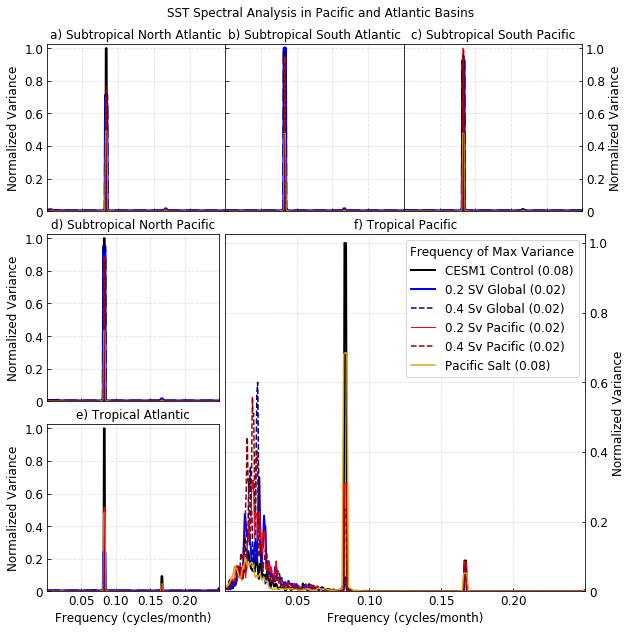

In [20]:
# --------------

a = u"\u00b0"
vanom1=-10
vanom2=10

fig = plt.figure(figsize=(8,8))

fig.suptitle('SST Spectral Analysis in Pacific and Atlantic Basins', fontsize=12, x=0.475, y=1.015)

# --------------

ax2 = plt.axes([0., 0.66, 0.31, 0.29])
ax2.set_title('a) Subtropical North Atlantic', fontsize=12)

ax2.plot(frqx_cntrl2, spcx_cntrl2/ax2_max, c='k', lw=2, ls='-')
ax2.plot(frqx_g02sv2, spcx_g02sv2/ax2_max, c='b', lw=3.5, ls='-')
ax2.plot(frqx_g04sv2, spcx_g04sv2/ax2_max, c='navy', lw=3.5, ls='--')
ax2.plot(frqx_p02sv2, spcx_p02sv2/ax2_max, c='red', lw=1., ls='-')
ax2.plot(frqx_p04sv2, spcx_p04sv2/ax2_max, c='darkred', lw=1., ls='--')
ax2.plot(frqx_psalt2, spcx_psalt2/ax2_max, c='goldenrod', lw=0.75, ls='-')

ax2.set_ylim([0,1.025])
ax2.set_xlim([0,0.2])
ax2.margins(x=0)
ax2.tick_params(axis='both', labelleft=True, direction='in', labelbottom=False)
ax2.grid(alpha=0.4, ls='--')
ax2.set_ylabel('Normalized Variance', fontsize=12)

ax2.set_xticks([0.05,0.1,.15,.2,.25])
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax2.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)

one=str(np.round(frqx_cntrl2[np.argmax(spcx_cntrl2)],2))

# --------------

ax6 = plt.axes([0.31, 0.66, 0.31, 0.29])
ax6.set_title('b) Subtropical South Atlantic', fontsize=12)

ax6.plot(frqx_cntrl5, spcx_cntrl5/ax6_max, c='k', lw=2, ls='-')
ax6.plot(frqx_g02sv5, spcx_g02sv5/ax6_max, c='b', lw=3.5, ls='-')
ax6.plot(frqx_g04sv5, spcx_g04sv5/ax6_max, c='navy', lw=3.5, ls='--')
ax6.plot(frqx_p02sv5, spcx_p02sv5/ax6_max, c='red', lw=1., ls='-')
ax6.plot(frqx_p04sv5, spcx_p04sv5/ax6_max, c='darkred', lw=1., ls='--')
ax6.plot(frqx_psalt5, spcx_psalt5/ax6_max, c='goldenrod', lw=0.75, ls='-')

ax6.margins(x=0)
ax6.set_ylim([0,1.025])
ax6.set_xlim([0,0.2])
ax6.tick_params(axis='both', labelleft=False, direction='in', labelbottom=False)
ax6.grid(alpha=0.4, ls='--')

ax6.set_xticks([0.05,0.1,.15,.2,.25])
ax6.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax6.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)

one=str(np.round(frqx_cntrl5[np.argmax(spcx_cntrl5)],2))

# --------------

ax5 = plt.axes([0.62, 0.66, 0.31, 0.29])
ax5.set_title('c) Subtropical South Pacific', fontsize=12)

ax5.plot(frqx_cntrl4, spcx_cntrl4/ax5_max, c='k', lw=2, ls='-')
ax5.plot(frqx_g02sv4, spcx_g02sv4/ax5_max, c='b', lw=3.5, ls='-')
ax5.plot(frqx_g04sv4, spcx_g04sv4/ax5_max, c='navy', lw=3.5, ls='--')
ax5.plot(frqx_p02sv4, spcx_p02sv4/ax5_max, c='red', lw=1., ls='-')
ax5.plot(frqx_p04sv4, spcx_p04sv4/ax5_max, c='darkred', lw=1., ls='--')
ax5.plot(frqx_psalt4, spcx_psalt4/ax5_max, c='goldenrod', lw=0.75, ls='-')

ax5.margins(x=0)
ax5.set_ylim([0,1.025])
ax5.set_xlim([0,0.2])
ax5.tick_params(axis='both', labelleft=False, labelright=True, direction='in', labelbottom=False)
ax5.grid(alpha=0.4, ls='--')
ax5.set_ylabel('Normalized Variance', fontsize=12)

ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()

ax5.set_xticks([0.05,0.1,.15,.2,.25])
ax5.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax5.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)

one=str(np.round(frqx_cntrl4[np.argmax(spcx_cntrl4)],2))

# --------------

ax1 = plt.axes([0., 0.33, 0.3, 0.29])
ax1.set_title('d) Subtropical North Pacific', fontsize=12)

ax1.plot(frqx_cntrl1, spcx_cntrl1/ax1_max, c='k', lw=2, ls='-')
ax1.plot(frqx_g02sv1, spcx_g02sv1/ax1_max, c='b', lw=3.5, ls='-')
ax1.plot(frqx_g04sv1, spcx_g04sv1/ax1_max, c='navy', lw=3.5, ls='--')
ax1.plot(frqx_p02sv1, spcx_p02sv1/ax1_max, c='red', lw=1., ls='-')
ax1.plot(frqx_p04sv1, spcx_p04sv1/ax1_max, c='darkred', lw=1., ls='--')
ax1.plot(frqx_psalt1, spcx_psalt1/ax1_max, c='goldenrod', lw=0.75, ls='-')

ax1.margins(x=0)
ax1.set_ylim([0,1.025])
ax1.set_xlim([0,0.2])
ax1.tick_params(axis='both', labelleft=True, direction='in', labelbottom=False)
ax1.grid(alpha=0.4, ls='--')
#ax1.set_ylabel('Variance (x10$^2$)', fontsize=12)
ax1.set_ylabel('Normalized Variance', fontsize=12)

ax1.set_xticks([0.05,0.1,.15,.2,.25])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)

one=str(np.round(frqx_cntrl1[np.argmax(spcx_cntrl1)],2))

# --------------

ax4 = plt.axes([0., 0., 0.3, 0.29])
ax4.set_title('e) Tropical Atlantic', fontsize=12)

ax4.plot(frqx_cntrl6, spcx_cntrl6/ax4_max, c='k', lw=2, ls='-')
ax4.plot(frqx_g02sv6, spcx_g02sv6/ax4_max, c='b', lw=3.5, ls='-')
ax4.plot(frqx_g04sv6, spcx_g04sv6/ax4_max, c='navy', lw=3.5, ls='--')
ax4.plot(frqx_p02sv6, spcx_p02sv6/ax4_max, c='red', lw=1., ls='-')
ax4.plot(frqx_p04sv6, spcx_p04sv6/ax4_max, c='darkred', lw=1., ls='--')
ax4.plot(frqx_psalt6, spcx_psalt6/ax4_max, c='goldenrod', lw=0.75, ls='-')

ax4.margins(x=0)
ax4.set_ylim([0,1.025])
ax4.set_xlim([0,0.2])
ax4.tick_params(axis='both', labelleft=True, direction='in', labelbottom=True)
ax4.grid(alpha=0.4, ls='--')
#ax4.set_ylabel('Variance (x10$^1$)', fontsize=12)
ax4.set_ylabel('Normalized Variance', fontsize=12)
ax4.set_xlabel('Frequency (cycles/month)', fontsize=12)

ax4.set_xticks([0.05,0.1,.15,.2,.25])
ax4.set_xticklabels(['0.05','0.10','0.15','0.20'], fontsize=12)
ax4.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax4.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)

one=str(np.round(frqx_cntrl6[np.argmax(spcx_cntrl6)],2))

# --------------

ax3 = plt.axes([0.31, 0., 0.625, 0.62])
ax3.set_title('f) Tropical Pacific', fontsize=12)

ln_ct, = ax3.plot(frqx_cntrl3, spcx_cntrl3/ax3_max, c='k', lw=2, ls='-')
ln_g2, = ax3.plot(frqx_g02sv3, spcx_g02sv3/ax3_max, c='b', lw=2., ls='-')
ln_g4, = ax3.plot(frqx_g04sv3, spcx_g04sv3/ax3_max, c='navy', lw=1.5, ls='--')
ln_p2, = ax3.plot(frqx_p02sv3, spcx_p02sv3/ax3_max, c='red', lw=1., ls='-')
ln_p4, = ax3.plot(frqx_p04sv3, spcx_p04sv3/ax3_max, c='darkred', lw=1.5, ls='--')
ln_p5, = ax3.plot(frqx_psalt3, spcx_psalt3/ax3_max, c='goldenrod', lw=1.5, ls='-')

ax3.margins(x=0)
ax3.set_ylim([0,1.025])
ax3.set_xlim([0,0.2])
ax3.tick_params(axis='both', labelleft=False, labelright=True, direction='in', labelbottom=True)
ax3.grid(alpha=0.4, ls='--')
#ax3.set_ylabel('Variance (x10$^1$)', fontsize=12)
ax3.set_ylabel('Normalized Variance', fontsize=12)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlabel('Frequency (cycles/month)', fontsize=12)

###
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax3.set_yticklabels([0,0.2,0.4,0.6,0.8,1.], fontsize=12)
ax3.set_xticks([0.05,0.1,.15,.2,.25])
ax3.set_xticklabels(['0.05','0.10','0.15','0.20'], fontsize=12)

one=str(np.round(frqx_cntrl3[np.argmax(spcx_cntrl3)],2))
two=str(np.round(frqx_g02sv3[np.argmax(spcx_g02sv3)],2))
thr=str(np.round(frqx_g04sv3[np.argmax(spcx_g04sv3)],2))
fou=str(np.round(frqx_p02sv3[np.argmax(spcx_p02sv3)],2))
fiv=str(np.round(frqx_p04sv3[np.argmax(spcx_p04sv3)],2))
six=str(np.round(frqx_psalt3[np.argmax(spcx_psalt3)],2))

leg = ax3.legend([ln_ct, ln_g2, ln_g4, ln_p2, ln_p4, ln_p5], 
                 [f'CESM1 Control ({one})', f'0.2 SV Global ({two})', f'0.4 Sv Global ({thr})', 
                 f'0.2 Sv Pacific ({fou})', f'0.4 Sv Pacific ({fiv})', f'Pacific Salt ({six})'],
                 ncol=1, loc='upper right', fontsize=12)

leg.set_title('Frequency of Max Variance',prop={'size':12})

# --------------

#plt.savefig(f'{directory_figs}amocenso_fig4.png', bbox_inches='tight', dpi=200)
plt.show()

# --------------